<a href="https://www.nvidia.com/dli"> <img src="../images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# 4.0 Build a Named-Entity Recognizer

In this notebook, you'll build an application that finds disease names in medical disease abstracts. The model does not "search" for names from a list, but rather "recognizes" that certain words are disease references from the context of the language.

**[4.1 Set Up the Project](#4.1-Set-Up-the-Project)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.1.1 Input Parameters](#4.1.1-Input-Parameters)<br>
**[4.2 Create Neural Modules](#4.2-Create-Neural-Modules)**<br>
**[4.3 Create Neural Graphs](#4.3-Create-Neural-Graphs)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.3.1 Training Graph](#4.3.1-Training-Graph)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.3.2 Exercise: Create the Validation Graph](#4.3.2-Exercise:-Create-the-Validation-Graph)<br>
**[4.4 Training](#4.4-Training)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.4.1 Set the Learning Rate and Optimizer](#4.4.1-Set-the-Learning-Rate-and-Optimizer)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.4.2 Exercise: Create the Callbacks](#4.4.2-Exercise:-Create-the-Callbacks)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.4.3 Run the Trainer](#4.4.3-Run-the-Trainer)<br>
**[4.5 Inference](#4.5-Inference)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.5.1 Create the Test Graph](#4.5.1-Create-the-Test-Graph)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.5.2 Run Inference on the Test Queries](#4.5.2-Run-Inference-on-the-Test-Queries)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.5.3 Inference Results](#4.5.3-Inference-Results)<br>
**[4.6 Exercise: Change the Language Model](#4.6-Exercise:-Change-the-Language-Model)**<br>

As we saw in the [1.0 Explore the Data](010_ExploreData.ipynb) notebook, the dataset for the NER project is made up of sentences with IOB tagging, where each word in a sentence is tagged as inside, outside, or the beginning of a named entity.  In the NER task, you'll follow the same basic steps as in the text classification task to build your project, train it, and test it, with a few differences:
* You'll learn to apply the *domain-specific* [BioBERT](https://news.developer.nvidia.com/biobert-optimized/) language model from an imported checkpoint, instead of one of the default pretrained models
* You'll use different neural modules appropriate for use with NER
* You'll learn to use a query-based technique for inference

BioBERT has the same network architecture as the original BERT, but instead of Wikipedia and BookCorpus, it is pretrained on PubMed, a large biomedical text corpus.  Starting with BioBERT instead of BERT achieves better performance in biomedical downstream tasks, such as question answering(QA), named entity recognition(NER) and relationship extraction(RE). This model was trained for 1M steps. For more information please refer to the original paper: [BioBERT: a pre-trained biomedical language representation model for biomedical text mining](https://academic.oup.com/bioinformatics/article/36/4/1234/5566506).

# 4.1 Set Up the Project
The NeMo setup pattern is the same for NER as for text classification, but some of the details are different.
* The "input data" consists of two files instead of one (text and labels)
* The data layers and classifiers work with "tokens" 
* We need to define a "none" label for the token padding, which we'll designate as "O", the symbol for "outside" in IOB

<img src="../images/nemo/nm-pipe.png" width=800>

Begin by importing libraries.  Note the specific classes and helpers that are imported below.  These are the ones you'll use to build your training, validation, and testing graphs.

In [1]:
# Import useful math and utility libraries
import os
import torch
import pandas as pd
import numpy as np
import time
import errno
import inspect
import termcolor

# Import the nemo toolkit and NLP libraries
import nemo
import nemo.collections.nlp as nemo_nlp

# Import the specific neural modules and module helpers we need
from nemo.collections.nlp.nm.data_layers import BertTokenClassificationDataLayer
from nemo.collections.nlp.nm.data_layers import BertTokenClassificationInferDataLayer
from nemo.collections.nlp.nm.trainables import get_pretrained_lm_model
from nemo.collections.nlp.nm.trainables import TokenClassifier
from nemo.backends.pytorch.common.losses import CrossEntropyLossNM

# Import helpers for fetching learning rate policy, tokenizer, vocabulary
from nemo.utils.lr_policies import get_lr_policy
from nemo.collections.nlp.data.tokenizers import get_tokenizer
from nemo.collections.nlp.utils.data_utils import get_vocab

# Import callbacks and callback functions
from nemo.core import SimpleLogger, TensorboardLogger, EvaluatorCallback, CheckpointCallback
from nemo.collections.nlp.callbacks.token_classification_callback import eval_epochs_done_callback, eval_iter_callback
from nemo import logging

[NeMo W 2020-07-25 22:13:54 audio_preprocessing:56] Could not import torchaudio. Some features might not work.


## 4.1.1 Input Parameters
The training text and label files are `text_train.txt` and `labels_train`, respectively.  The validation and test files follow a similar naming pattern. Verify the location of the data files. 

In [2]:
!ls -lh /dli/task/data/NCBI_ner-3/

total 4.0M
-rw-r--r-- 1 702112 10513  181K Jul 13 21:10 dev.tsv
-rw-r--r-- 1 702112 10513     5 Jul 13 21:10 label_ids.csv
-rw-r--r-- 1 702112 10513    52 Jul 13 21:10 label_stats.tsv
-rw-r--r-- 1 702112 10513   48K Jul 13 21:10 labels_dev.txt
-rw-r--r-- 1 702112 10513   49K Jul 13 21:10 labels_test.txt
-rw-r--r-- 1 702112 10513  271K Jul 13 21:10 labels_train.txt
-rw-r--r-- 1 702112 10513  185K Jul 13 21:10 test.tsv
-rw-r--r-- 1 702112 10513  135K Jul 13 21:10 text_dev.txt
-rw-r--r-- 1 702112 10513  138K Jul 13 21:10 text_test.txt
-rw-r--r-- 1 702112 10513  758K Jul 13 21:10 text_train.txt
-rw-r--r-- 1 702112 10513 1023K Jul 13 21:10 train.tsv
-rw-r--r-- 1 702112 10513  1.2M Jul 13 21:10 train_dev.tsv


### IOB Tagging
Recall that the sentences and labels in the NER dataset map to each other with _inside, outside, beginning (IOB)_ tagging.
This mechanism can be used in a general way for multiple named entity types:
* B-{CHUNK_TYPE} – for the word in the Beginning chunk
* I-{CHUNK_TYPE} – for words Inside the chunk
* O – Outside any chunk

In our case, we are only looking for "disease" as our entity (or chunk) type, so we don't need to identify beyond the three classes: I, O, and B.
**Three classes**
* B - Begiining of disease name
* I - Inside word of disease name
* O - Outside of all disease names

```text
Identification of APC2 , a homologue of the adenomatous polyposis coli tumour suppressor .
O              O  O    O O O         O  O   B           I         I    I      O          O  
```

If we were looking for two kinds of named entities, such as nouns and verbs in a parts-of-speech analysis, we would use a five-class IOB scheme:<br>
**Five classes**
* B-N - Beginning of noun word or phrase
* I-N - Inside noun word or phrase
* B-V - Beginning of verb word or phrase
* I-V - Inside verb word or phrase
* O   - Outside all nouns and verbs

If you are intereested in learning more, take a look at [this paper](http://cs229.stanford.edu/proj2005/KrishnanGanapathy-NamedEntityRecognition.pdf) on the subject.

### Domain-Specific Checkpoint
We also need the checkpoints and configuration files for our domain-specific language models.  Specific checkpoints pretrained for BioBERT and BioMegatron can be downloaded from [NVIDIA NGC Models](https://ngc.nvidia.com/catalog/models):<br><br>
For BioBERT  https://ngc.nvidia.com/catalog/models/nvidia:biobertbasecasedfornemo.<br>
For BioMegatron  https://ngc.nvidia.com/catalog/models/nvidia:biomegatron345muncased.

**You don't need to download them for this course**, as that has already been done.  Run the next cell to see where the checkpoint files (.pt) and config files (.json) are located in the file system.

In [3]:
!tree /ngc_checkpoints

/ngc_checkpoints
└── checkpoints
    ├── biobert
    │   ├── BERT.pt
    │   ├── SequenceClassifier.pt
    │   ├── TokenClassifier.pt
    │   └── bert_config.json
    └── biomegatron
        ├── MegatronBERT.pt
        ├── config.json
        └── vocab.txt

3 directories, 7 files


We'll set up all the locations and pre-set parameters for the model.  If you want to try a different model later, you can restart the notebook kernel, then change MODEL_TYPE here.  

In [4]:
# Identify the input data location
DATA_DIR = '/dli/task/data/NCBI_ner-3/'

# Identify downloaded checkpoints location
CHECKPOINTS_PATH = '/ngc_checkpoints/checkpoints/' 

# Select which model you want to use, either biobert or biomegatron
MODEL_TYPE = "biobert"
# MODEL_TYPE = "biomegatron"

# Set the number of words in the sequences
# Shorter sequences will be padded with NONE_LABEL, longer ones truncated
MAX_SEQ_LEN = 128 
BATCH_SIZE = 16
NONE_LABEL = "O" 
NUM_CLASSES = 3 # IOB (inside, outside, beginning)

In [5]:
# Set up dictionaries for other parameters that key off the MODEL_TYPE
PRETRAINED_MODEL_NAME = {'biobert': 'bert-base-cased', 
                         'biomegatron': 'megatron-bert-uncased'}
DO_LOWER_CASE = {'biobert': False, 
               'biomegatron': True}
WORK_DIR = {'biobert': '/dli/task/data/logs-ner-biobert/', 
            'biomegatron': '/dli/task/data/logs-ner-biomegatron'}

# Map downloaded ngc models to MODEL_TYPE
NGC_CHECKPOINT = {'biobert': CHECKPOINTS_PATH + 'biobert/BERT.pt', 
                  'biomegatron': CHECKPOINTS_PATH + 'biomegatron/MegatronBERT.pt'}
NGC_CONFIG = {'biobert': CHECKPOINTS_PATH + 'biobert/bert_config.json', 
              'biomegatron': CHECKPOINTS_PATH + 'biomegatron/config.json'}

# 4.2 Create Neural Modules

<figure>
    <img src="../images/nemo/ner_graph.png" width=800>
    <figcaption style="text-align:center;">NER Graph</figcaption>
</figure>

As always, begin by instantiating the neural module factory before building anything else.

In [6]:
# Instantiate the neural module factory
nf = nemo.core.NeuralModuleFactory(log_dir=WORK_DIR[MODEL_TYPE],
                                   create_tb_writer=True,
                                   placement=nemo.core.DeviceType.GPU)

Training and validation each need a datalayer neural module instantiatted with `BertTokenClassificationDataLayer`.  As a reminder of the inputs required, inspect the signature.

In [7]:
inspect.signature(BertTokenClassificationDataLayer)

<Signature (text_file, label_file, tokenizer, max_seq_length, pad_label='O', label_ids=None, num_samples=-1, shuffle=False, batch_size=64, ignore_extra_tokens=False, ignore_start_end=False, use_cache=False, dataset_type=<class 'nemo.collections.nlp.data.datasets.token_classification_dataset.BertTokenClassificationDataset'>)>

The `text_file`, `label_file`, `tokenizer`, `max_seq_length` are all required. The only one of those four items we don't have yet is the tokenizer, so we'll set it up before we set up the data layers.  

Of the optional parameters, it looks like the default for pad_label is the one we want already, but shuffle needs to be set to `True` for training, and for convenience we want to use a cache, so `use_cache` needs to be `True`.  We also need to use a different value for `batch_size`. The rest is good to go.

In the next cell, the tokenizer and training data layer neural module are instantiated to get you started.  

In [8]:
# Instantiate the data Layer neural module for training.
#     Include the input file locations, tokenizer, max_seq_length, and batch size.
#     Set the shuffle and use_cache to True for training 
USE_CACHE = True
tokenizer = get_tokenizer(
    tokenizer_name='nemobert',
    pretrained_model_name = PRETRAINED_MODEL_NAME[MODEL_TYPE],
    do_lower_case=DO_LOWER_CASE[MODEL_TYPE]
)
dl_train = BertTokenClassificationDataLayer(
    text_file=os.path.join(DATA_DIR,'text_train.txt'),
    label_file=os.path.join(DATA_DIR,'labels_train.txt'),
    tokenizer=tokenizer,
    max_seq_length=MAX_SEQ_LEN,
    shuffle=True,
    batch_size=BATCH_SIZE,
    use_cache=USE_CACHE
)

[NeMo I 2020-07-25 22:13:58 bert_tokenizer:78] Deriving bert model type from pretrained model name.



[NeMo I 2020-07-25 22:13:59 token_classification_dataset:273] Creating a new label to label_id dictionary. It's recommended to use label_ids generated during training for dev/test sets to avoid errors if some labels are not present in the dev/test sets. For training set label_ids should be None.
[NeMo I 2020-07-25 22:14:06 token_classification_dataset:116] Max length: 128
[NeMo I 2020-07-25 22:14:06 data_preprocessing:250] Min: 4 |                  Max: 178 |                  Mean: 35.938237463126846 |                  Median: 34.0
[NeMo I 2020-07-25 22:14:06 data_preprocessing:252] 75 percentile: 45.0
[NeMo I 2020-07-25 22:14:06 data_preprocessing:253] 99 percentile: 88.76999999999953


[NeMo W 2020-07-25 22:14:06 token_classification_dataset:145] 8 are longer than 128


[NeMo I 2020-07-25 22:14:06 token_classification_dataset:148] *** Example ***
[NeMo I 2020-07-25 22:14:06 token_classification_dataset:149] i: 0
[NeMo I 2020-07-25 22:14:06 token_classification_dataset:150] subtokens: [CLS] I ##dent ##ification of AP ##C ##2 , a ho ##mo ##logue of the ad ##eno ##mat ##ous p ##oly ##po ##sis co ##li t ##umour suppress ##or . [SEP]
[NeMo I 2020-07-25 22:14:06 token_classification_dataset:151] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2020-07-25 22:14:06 token_classification_dataset:152] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In the next four cells, instantiate:
1. Validation data layer neural module
1. Language model neural module
1. Token classification model neural module
1. Loss neural module

Look for and fix the <i><strong><span style="color:green;">#FIXME</span><strong></i> code lines.  If you get stuck, look back at the [2.0 NLP Projects with NeMo](020_ExploreNeMo.ipynb) notebook for inspiration or the [solution notebook](solution_notebooks/SOLN_040_NamedEntityRecogntion.ipynb) for the answer.

In [9]:
# 1. Instantiate the data Layer neural module for validation.
#     Include the input file locations, tokenizer, max_seq_length, and batch size.
#     Set the shuffle to False (the default value) and use_cache to True for validation  
dl_val = BertTokenClassificationDataLayer(
    text_file=os.path.join(DATA_DIR,'text_dev.txt'),
    label_file=os.path.join(DATA_DIR,'labels_dev.txt'),
    tokenizer=tokenizer,
    max_seq_length=MAX_SEQ_LEN,
    batch_size=BATCH_SIZE,
    use_cache=USE_CACHE
)

[NeMo I 2020-07-25 22:14:06 token_classification_dataset:273] Creating a new label to label_id dictionary. It's recommended to use label_ids generated during training for dev/test sets to avoid errors if some labels are not present in the dev/test sets. For training set label_ids should be None.
[NeMo I 2020-07-25 22:14:08 token_classification_dataset:116] Max length: 122
[NeMo I 2020-07-25 22:14:08 data_preprocessing:250] Min: 4 |                  Max: 122 |                  Mean: 36.812567713976165 |                  Median: 34.0
[NeMo I 2020-07-25 22:14:08 data_preprocessing:252] 75 percentile: 47.0
[NeMo I 2020-07-25 22:14:08 data_preprocessing:253] 99 percentile: 83.55999999999995


[NeMo W 2020-07-25 22:14:08 token_classification_dataset:145] 0 are longer than 122


[NeMo I 2020-07-25 22:14:08 token_classification_dataset:148] *** Example ***
[NeMo I 2020-07-25 22:14:08 token_classification_dataset:149] i: 0
[NeMo I 2020-07-25 22:14:08 token_classification_dataset:150] subtokens: [CLS] BR ##CA ##1 is secret ##ed and exhibits properties of a g ##rani ##n . [SEP]
[NeMo I 2020-07-25 22:14:08 token_classification_dataset:151] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2020-07-25 22:14:08 token_classification_dataset:152] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2020-07-25 22:14:08 token_classification_dataset:153] su

In [10]:
# 2. Instantiate the Language Model with the get_pretrained_lm_model function
#    Since we are defining the checkpoint, include the file locations as values for
#    "config=", "pretrained_model_name=", and "checkpoint="
#    Hint: We set these values up earlier with dictionaries keyed off the MODEL_TYPE
lm = get_pretrained_lm_model(config=NGC_CONFIG[MODEL_TYPE],
                                pretrained_model_name=PRETRAINED_MODEL_NAME[MODEL_TYPE],
                                checkpoint=NGC_CHECKPOINT[MODEL_TYPE]
    )

# Sanity check the number of weight parameters
#    It should be 108,310,272 for `bert-base-cased`
print(f'{PRETRAINED_MODEL_NAME[MODEL_TYPE]} has {lm.num_weights} weights')

[NeMo I 2020-07-25 22:14:12 common_utils:85] bert-base-cased model restored from /ngc_checkpoints/checkpoints/biobert/BERT.pt
bert-base-cased has 108310272 weights


In [11]:
# 3. Instantiate the TokenClassifier
#    Include the hidden_size, num_classes (which is 3), num_layers (set to 1), 
#    and a dropout rate of 0.1
lm_hidden_size = lm.hidden_size
classifier = TokenClassifier(hidden_size=lm_hidden_size, 
            num_classes=NUM_CLASSES, 
            dropout=0.1, 
            num_layers=1)

# Sanity check the number of weight parameters
#    It should be 2307
print(f'Classifier has {classifier.num_weights} weights')

Classifier has 2307 weights


In [12]:
# 4. Instantiate the CrossEntropyLossNM Loss Function 
#  Set the logits_ndim value to 3
loss = CrossEntropyLossNM(logits_ndim=3)

Great job!  Your neural modules are set up.

# 4.3 Create Neural Graphs

Define the neural graphs by linking the output of each neural module with the input of the next one in the pipeline.

## 4.3.1 Training Graph

<figure>
    <img src="../images/nemo/ner_train_graph.png" width=800>
    <figcaption style="text-align:center;">Training Graph</figcaption>
</figure>
As before, we'll use the outputs for each neural module to define the inputs of the next one in the pipeline. 

In [13]:
# Define the data output from the data layer
train_data = dl_train()

# Define train_embeddings from the language model, based on inputs from the data layer  
train_embeddings = lm(input_ids=train_data.input_ids, token_type_ids=train_data.input_type_ids, attention_mask=train_data.input_mask)

# Define the train_logits from the clasifier, based on the embeddings from the language model
train_logits = classifier(hidden_states=train_embeddings)

# Define the train_loss based on the classifier logits and data layer labels
train_loss = loss(logits=train_logits, labels=train_data.labels, loss_mask=train_data.loss_mask)

You may have noticed that the `train_data` assignment is slightly more concise than the explicit tuple we used in the text classification notebook.  
We set `train_data = dl_train()` to create the link in our graph from the data layer and into the language model.  The variable names are defined in NeMo, giving us convenient access, e.g. `train_data.input_ids`, `train_data.input_type_ids`, and so on.  Here's a list from the [`BertTokenClassificationDataLayer` source code](https://github.com/NVIDIA/NeMo/blob/3d6ae0589c1bf0fed2cb038ac80590bebe738e3d/nemo/collections/nlp/nm/data_layers/token_classification_datalayer.py):

```python
    def output_ports(self):
        """Returns definitions of module output ports.
        input_ids:
            indices of tokens which constitute batches of text segments
        input_type_ids:
            tensor with 0's and 1's to denote the text segment type
        input_mask:
            bool tensor with 0s in place of tokens to be masked
        loss_mask:
            used to mask and ignore tokens in the loss function
        subtokens_mask:
            used to mask all but the first subtoken of the work, could be useful during inference
        labels:
            token target ids
        """
 ```           

## 4.3.2 Exercise: Create a Validation Graph

The validation graph is very similar to the training graph. In fact, only the data layer module is different. 

<figure>
    <img src="../images/nemo/ner_val_graph.png" width=800>
    <figcaption style="text-align:center;">Validation Graph</figcaption>
</figure>

In the cell below, look for and fix the <i><strong><span style="color:green;">#FIXME</span><strong></i> code lines (there are four of them).  If you get stuck, look back at the training graph you just set up for inspiration or the [solution notebook](solution_notebooks/SOLN_040_NamedEntityRecognition.ipynb) for the answer.

In [14]:
# Define the data output from the data layer
val_data = dl_val()

# Define val_embeddings from the language model, based on inputs from the data layer  
val_embeddings = lm(input_ids=val_data.input_ids, 
                       token_type_ids=val_data.input_type_ids, 
                       attention_mask=val_data.input_mask)

# Define val_logits from the classifier, based on the embeddings from the language model
val_logits = classifier(hidden_states=val_embeddings)

# Define val_loss based on the classifier logits and data layer labels
val_loss = loss(logits=val_logits, labels=val_data.labels, loss_mask=val_data.loss_mask)

Great!  You're pipelines are ready for training.

# 4.4 Training
Now that the graphs are set up, the action can begin.  You'll train the model with the NeuralModuleFactory `.train()` function. 

## 4.4.1 Set the Learning Rate and Optimizer
For NER, we'll set the learning rate to 0.00004 and use `WarmupAnnealing`.  We'll use the popular [`adam_w`](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw-pytorch) optimizer (with "weight decay"). 

In [15]:
NUM_EPOCHS = 4
OPTIMIZER = 'adam_w'
LEARNING_RATE = 4e-5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

# If you're training on multiple GPUs, this should be
# len(train_data_layer) // (batch_size * batches_per_step * num_gpus)
steps_per_epoch = len(dl_train) // BATCH_SIZE
logging.info(f"doing {steps_per_epoch} steps per epoch")
lr_policy_fn = get_lr_policy("WarmupAnnealing", 
                             total_steps=NUM_EPOCHS * steps_per_epoch, 
                             warmup_ratio=WARMUP_RATIO
)

[NeMo I 2020-07-25 22:14:12 <ipython-input-15-cf826b6bfd52>:10] doing 339 steps per epoch


## 4.4.2 Exercise: Create the Callbacks
NeMo has a callback system that can be used to inject user code and logic inside its training loop. You can find references for the newest built-in callbacks in the NeMo Documentation:  

* [SimpleLogger](https://nvidia.github.io/NeMo/api-docs/nemo.html#nemo.core.callbacks.SimpleLogger)
* [TensorboardLogger](https://nvidia.github.io/NeMo/api-docs/nemo.html#nemo.core.callbacks.TensorboardLogger)
* [CheckpointCallBack](https://nvidia.github.io/NeMo/api-docs/nemo.html#nemo.core.callbacks.CheckpointCallback)

In the cell below, create the callbacks, just as we did in the text classification project.  This time, specify a `step_freq=100` value. 

Look for and fix the <i><strong><span style="color:green;">#FIXME</span><strong></i> code lines.  If you get stuck, look back at the [3.0 Build a 3-Class Text Classifier](030_TextClassification.ipynb) notebook for inspiration or the [solution notebook](solution_notebooks/SOLN_040_NamedEntityRecogntion.ipynb) for the answer.

In [16]:
train_callback = SimpleLogger(step_freq=100)

tensorboard_callback = TensorboardLogger(nf.tb_writer, step_freq=steps_per_epoch)

# Callback to evaluate the model
eval_callback = EvaluatorCallback(
        eval_tensors=[val_logits, val_data.labels, val_data.subtokens_mask],
        user_iter_callback=lambda x, y: eval_iter_callback(x, y),
        user_epochs_done_callback=lambda x: eval_epochs_done_callback(x, dl_train.dataset.label_ids,
                                                                      f'{nf.work_dir}/graphs'),
        tb_writer=nf.tb_writer,
        eval_step=steps_per_epoch
    )

# Create callback to save checkpoints
ckpt_callback = CheckpointCallback(folder=nf.checkpoint_dir,
                                             epoch_freq=1)

## 4.4.3 Run the Trainer

[NeMo I 2020-07-25 22:14:12 callbacks:534] Found 2 modules with weights:
[NeMo I 2020-07-25 22:14:12 callbacks:536] BERT
[NeMo I 2020-07-25 22:14:12 callbacks:536] tokenclassifier0
[NeMo I 2020-07-25 22:14:12 callbacks:537] Total model parameters: 108312579
[NeMo I 2020-07-25 22:14:12 callbacks:473] Found checkpoint folder /dli/task/data/logs-ner-biobert/checkpoints. Will attempt to restore checkpoints from it.


[NeMo W 2020-07-25 22:14:12 callbacks:499] For module BERT, no file matches  in /dli/task/data/logs-ner-biobert/checkpoints
[NeMo W 2020-07-25 22:14:12 callbacks:501] Checkpoint folder /dli/task/data/logs-ner-biobert/checkpoints was present but nothing was restored. Continuing training from random initialization.


[NeMo I 2020-07-25 22:14:13 callbacks:232] loss: 1.1512176
[NeMo I 2020-07-25 22:14:13 deprecated_callbacks:316] Doing Evaluation ..............................
[NeMo I 2020-07-25 22:14:16 token_classification_callback:78] Sampled preds: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[NeMo I 2020-07-25 22:14:16 token_classification_callback:79] Sampled labels: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[NeMo I 2020-07-25 22:14:16 token_classification_callback:82] Accuracy: 0.2067670741374275
[NeMo I 2020-07-25 22:14:16 token_classification_callback:86] F1 weighted: 29.83
[NeMo I 2020-07-25 22:14:16 token_classification_callback:86] F1 macro: 15.34
[NeMo I 2020-07-25 22:14:16 token_classification_callback:86] F1 micro: 20.68
[NeMo I 2020-07-25 22:14:16 token_classification_callback:89]                  precision    recall  f1-score   support
    
    O (label id: 0)     0.9378    0.1912    0.3176     22092
    B (label id: 1)     0.0354    0.8145    0.0679       787
    I (label id: 2)     0.

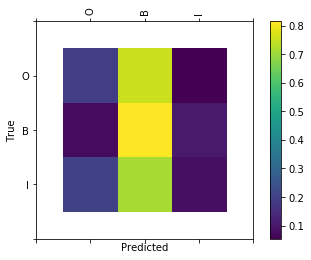

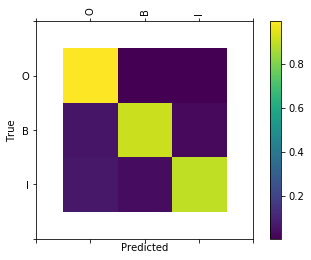

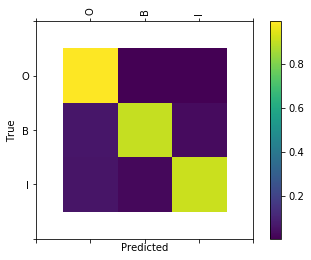

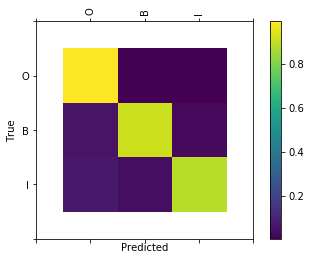

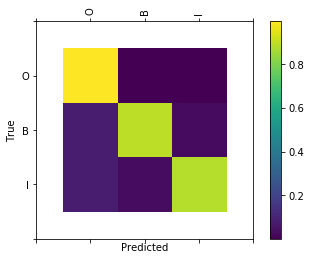

In [17]:
nemo.core.NeuralModuleFactory.reset_trainer(nf)

nf.train(
    tensors_to_optimize=[train_loss],
    callbacks=[train_callback, tensorboard_callback, eval_callback, ckpt_callback],
    lr_policy=lr_policy_fn,
    optimizer=OPTIMIZER,
    optimization_params={"num_epochs": NUM_EPOCHS, "lr": LEARNING_RATE, "weight_decay": WEIGHT_DECAY}
    
)

The results should look something like:
```
[NeMo I 2020-05-22 17:13:48 token_classification_callback:82] Accuracy: 0.9882348032875798
[NeMo I 2020-05-22 17:13:48 token_classification_callback:86] F1 weighted: 98.82
[NeMo I 2020-05-22 17:13:48 token_classification_callback:86] F1 macro: 93.74
[NeMo I 2020-05-22 17:13:48 token_classification_callback:86] F1 micro: 98.82
[NeMo I 2020-05-22 17:13:49 token_classification_callback:89] precision    recall  f1-score   support
    
    O (label id: 0)     0.9938    0.9957    0.9947     22092
    B (label id: 1)     0.8843    0.9034    0.8938       787
    I (label id: 2)     0.9505    0.8982    0.9236      1090
    
           accuracy                         0.9882     23969
          macro avg     0.9429    0.9324    0.9374     23969
       weighted avg     0.9882    0.9882    0.9882     23969
```
The final confusion matrix visualization shows a bright diagonal, indicating that the predicted label matched the true label with high accuracy for all the label types (IOB).

<img src="../images/ner_confusion_matrix.png">

# 4.5 Inference
We have a test set, which we can read with *pandas*, then sample and export into whatever format we need.  We ultimately want a manageable number of sentences in a list, that we can submit directly to a data layer neural module.  In the text classification example, we provided the data layer with a filename, but this time, we'll just pass a query list.

In [18]:
# Import the text data and sanity-check it 
df_test = pd.read_csv(DATA_DIR + 'text_test.txt', sep='\t', names=['sentence'])
print('The size of the test samples DataFrame: {}'.format(df_test.shape))
df_test.head()

The size of the test samples DataFrame: (450, 1)


,sentence
0,Clustering of missense mutations in the ataxia...
1,Ataxia - telangiectasia ( A - T ) is a recessi...
2,"The risk of cancer , especially lymphoid neopl..."
3,By analysing tumour DNA from patients with spo...
4,In marked contrast to the ATM mutation pattern...


In [19]:
# Grab a small number (such as 10) of random samples and save them
df_test = df_test.sample(10)
df_test.shape
queries = df_test['sentence'].values.tolist()
print(queries)

['We conclude that these mice very closely mimic severe human von Willebrand disease and will be very useful for investigating the role of vWf in normal physiology and in disease models . . ', 'We report here the complete characterization of the 48 exons of the COL4A4 gene , a comprehensive gene screen , and the subsequent detection of 10 novel mutations in eight patients diagnosed with autosomal recessive Alport syndrome . ', 'In a survey of DM in Northern Ireland , 59 pedigrees were ascertained . ', 'PAX6 regulates eye development in animals ranging from jellyfish to Drosophila to humans . ', 'Deficiency of the sixth component of human complement ( C6 ) has been reported in a number of families from the western Cape , South Africa . ', 'Three of 13 uninformative patients had constitutional deletions . ', 'Molecular genetic analysis of her VLCAD gene revealed a T1372C ( F458L ) missense mutation and a 1668 ACAG 1669 splice site mutation . ', 'The analysis of tumors from 54 ( 71 % ) of

## 4.5.1 Create the Test Graph
<figure>
    <img src="../images/nemo/ner_test_graph.png" width=600>
    <figcaption style="text-align:center;">Test Graph</figcaption>
</figure>

We'll use a different data layer neural module called `BertTokenClassificationInferDataLayer`, so that we can use a direct list as input instead of a file (the `queries=` parameter).

In [20]:
# Define a data layer neural module for the test set
dl_test = BertTokenClassificationInferDataLayer(
    tokenizer=tokenizer,
    queries=queries,
    max_seq_length=MAX_SEQ_LEN,
    batch_size=1
)

[NeMo I 2020-07-25 22:18:02 token_classification_dataset:116] Max length: 59
[NeMo I 2020-07-25 22:18:02 data_preprocessing:250] Min: 16 |                  Max: 59 |                  Mean: 33.8 |                  Median: 34.0
[NeMo I 2020-07-25 22:18:02 data_preprocessing:252] 75 percentile: 40.5
[NeMo I 2020-07-25 22:18:02 data_preprocessing:253] 99 percentile: 58.190000000000005


[NeMo W 2020-07-25 22:18:02 token_classification_dataset:145] 0 are longer than 59


[NeMo I 2020-07-25 22:18:02 token_classification_dataset:148] *** Example ***
[NeMo I 2020-07-25 22:18:02 token_classification_dataset:149] i: 0
[NeMo I 2020-07-25 22:18:02 token_classification_dataset:150] subtokens: [CLS] We conclude that these mice very closely mimic severe human von Will ##eb ##rand disease and will be very useful for investigating the role of v ##W ##f in normal physiology and in disease models . . [SEP]
[NeMo I 2020-07-25 22:18:02 token_classification_dataset:151] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2020-07-25 22:18:02 token_classification_dataset:152] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[NeMo I 2020-07-25 22:18:02 token_classification_dataset:153] subtokens_mask: 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [21]:
# Define all the neural graph connections
test_data = dl_test()
test_embeddings = lm(input_ids=test_data.input_ids, 
                           token_type_ids=test_data.input_type_ids, 
                           attention_mask=test_data.input_mask)
test_logits = classifier(hidden_states=test_embeddings)

## 4.5.2 Run Inference on the Test Set
Start the action!

In [22]:
test_logits_tensors = nf.infer(tensors=[test_logits, test_data.subtokens_mask])

[NeMo I 2020-07-25 22:18:02 actions:695] Evaluating batch 0 out of 10
[NeMo I 2020-07-25 22:18:02 actions:695] Evaluating batch 1 out of 10
[NeMo I 2020-07-25 22:18:02 actions:695] Evaluating batch 2 out of 10
[NeMo I 2020-07-25 22:18:02 actions:695] Evaluating batch 3 out of 10
[NeMo I 2020-07-25 22:18:02 actions:695] Evaluating batch 4 out of 10
[NeMo I 2020-07-25 22:18:03 actions:695] Evaluating batch 5 out of 10
[NeMo I 2020-07-25 22:18:03 actions:695] Evaluating batch 6 out of 10
[NeMo I 2020-07-25 22:18:03 actions:695] Evaluating batch 7 out of 10
[NeMo I 2020-07-25 22:18:03 actions:695] Evaluating batch 8 out of 10
[NeMo I 2020-07-25 22:18:03 actions:695] Evaluating batch 9 out of 10


# 4.5.3 Inference Results
To view the results, we'll gather the resulting output tensors and map them to the words in the `queries` list.

In [23]:
# Gather the results
def concatenate(lists):
    return np.concatenate([t.cpu() for t in lists])

def add_brackets(text, add=True):
    return '[' + text + ']' if add else text

logits, subtokens_mask = [concatenate(tensors) for tensors in test_logits_tensors]
preds = np.argmax(logits, axis=2)

In [26]:
# Iterate through the queries and display the IOB tags
blue_separator = termcolor.colored('----------------------------', color='blue')
green_separator = termcolor.colored('*****************************\n*****************************', color='green')
labels_dict = DATA_DIR + "label_ids.csv"
labels_dict = get_vocab(labels_dict)

for i, query in enumerate(queries):
    print(f'Query:\n{query}')
    
    pred = preds[i][subtokens_mask[i] > 0.5]
    words = query.strip().split()
    output = ''
    
    for j, w in enumerate(words):
        output += w
        label = labels_dict[pred[j]]
        if label != NONE_LABEL:
            label = add_brackets(label)
            output += label
        output += ' '
        
    print(f'{blue_separator}\nLabeled Result:\n{output.strip()}\n{green_separator}')

Query:
We conclude that these mice very closely mimic severe human von Willebrand disease and will be very useful for investigating the role of vWf in normal physiology and in disease models . . 
----------------------------
Labeled Result:
We conclude that these mice very closely mimic severe human von[B] Willebrand[I] disease[I] and will be very useful for investigating the role of vWf in normal physiology and in disease models . .
*****************************
*****************************
Query:
We report here the complete characterization of the 48 exons of the COL4A4 gene , a comprehensive gene screen , and the subsequent detection of 10 novel mutations in eight patients diagnosed with autosomal recessive Alport syndrome . 
----------------------------
Labeled Result:
We report here the complete characterization of the 48 exons of the COL4A4 gene , a comprehensive gene screen , and the subsequent detection of 10 novel mutations in eight patients diagnosed with autosomal recessive

# 4.6 Exercise: Change the Language Model
Now that you've built the project, you can experiment with different settings, and try the BioMegatron model.   To do that, you'll need to restart the kernel to clear memory, and change the `MODEL_TYPE` value in the [4.1.1 Input Parameters](4.1.1-Input-Parameters) section. 

<h2 style="color:green;">Congratulations!</h2>

You've built a NER project that recognizes disease names.  You're ready to take your assessmet.<br>

Move on to [5.0 Assessment](050_Assessment.ipynb).

<a href="https://www.nvidia.com/dli"> <img src="../images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>